In [1]:
# Standard code libraries
import os
import platform
import glob

import numpy as np
import scipy
import matplotlib.pyplot as plt

# Custom code libraries from the ReSurfEMG
from resurfemg.config.config import Config
from resurfemg.data_connector.tmsisdk_lite import Poly5Reader
from resurfemg.data_classes.data_classes import (
    TimeSeriesGroup, VentilatorDataGroup, EmgDataGroup)

%matplotlib widget

## 2. Load the ventilator and sEMG data

In [2]:
# Root directory for test data
config = Config()
root_patient_data_directory = \
    config.get_directory('test_data')

if platform.system() == 'Windows':
    path_sep = "\\"
else:
    path_sep = '/'

# Identify all recordings available for the selected patient/measurement_date
emg_pattern = os.path.join(root_patient_data_directory, '**/*.Poly5')
emg_and_vent_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
vent_files = []

for file in emg_and_vent_files:
    if 'vent' in file:
        vent_files.append(file)
    else:
        emg_files.append(file)

emg_file_chosen = emg_files[0]
vent_file_chosen = vent_files[0]
print("The chosen files are:\n", emg_file_chosen, '\n', vent_file_chosen)

The chosen files are:
 C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/test_data\emg_data_synth_pocc.Poly5 
 C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/test_data\vent_data_synth_pocc.Poly5


In [3]:
# Load the EMG and ventilator data recordings from the selected folders.
data_emg = Poly5Reader(emg_file_chosen)
data_vent = Poly5Reader(vent_file_chosen)
data_emg_samples = data_emg.samples[:data_emg.num_samples]
fs_emg = data_emg.sample_rate
data_vent_samples = data_vent.samples[:data_vent.num_samples]
fs_vent = data_vent.sample_rate

# Define the time series of the EMG and ventilator recordings
y_emg = data_emg_samples
y_vent = data_vent_samples

# Define the time axes
t_emg = [i/fs_emg for i in range(len(y_emg[0, :]))]
t_vent = [i/fs_vent for i in range(len(y_vent[0, :]))]

# Default settings for window of interest including the end-expiratory occlusion
# manoeuvres (Pocc)
t_start_default = t_vent[-1]-60
t_end_default = t_vent[-1]-5

Reading file  C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/test_data\emg_data_synth_pocc.Poly5
	 Number of samples:  860160 
	 Number of channels:  2 
	 Sample rate: 2048 Hz
Done reading data.
Reading file  C:/Users/warnaarrsp/repos/ReSurfEMG_ReSurfEMG/test_data\vent_data_synth_pocc.Poly5
	 Number of samples:  42000 
	 Number of channels:  3 
	 Sample rate: 100 Hz
Done reading data.


In [4]:
emg_timeseries = EmgDataGroup(y_emg, fs=fs_emg, labels=['ECG', 'EMGdi'], units=3*['uV'])
emg_timeseries.filter()
emg_timeseries.gating()
emg_timeseries.envelope(signal_type='clean')
emg_timeseries.baseline()

Auto-detected ECG channel.


In [5]:
vent_timeseries = VentilatorDataGroup(y_vent, fs=fs_vent, labels=['Paw', 'F', 'Vvent'], units=['cmH2O', 'L/s', 'L'])
vent_timeseries.baseline(channel_idxs=[0], signal_type='raw')

(370.0, 410.0)

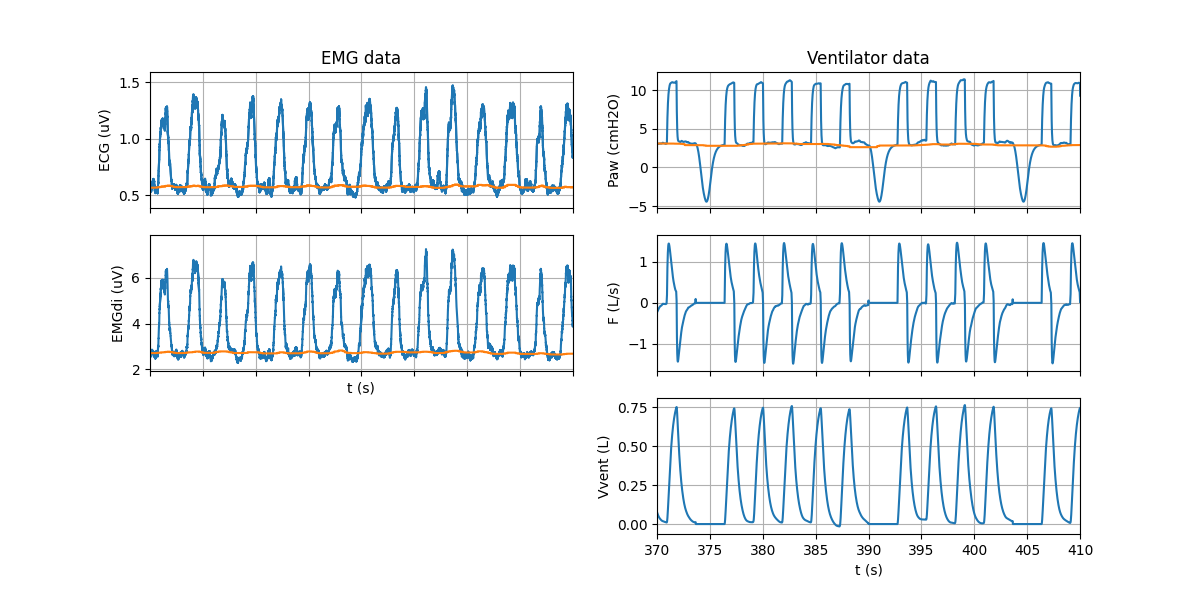

In [11]:
# Plot the raw data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(12, 6), sharex=True)
axes_emg = axis[:2, 0]
colors = ['tab:cyan', 'tab:orange']
# emg_timeseries.plot_full(axes_emg, signal_type='clean', baseline_bool=False)
# emg_timeseries.plot_full(axes_emg, signal_type='env', colors=colors)
emg_timeseries.plot_full(axes_emg, signal_type='env')
emg_timeseries.plot_full(axes_emg[0], channel_idxs=0, signal_type='env')
axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

axes_vent = axis[:, 1]
vent_timeseries.plot_full(axes_vent)
axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')

axis[-1, 0].axis('off')

axes_vent[-1].set_xlim([370, 410])

In [12]:
# Find occlusion pressures
vent_timeseries.peep
vent_timeseries.find_occluded_breaths(
    vent_timeseries.p_aw_idx, start_s=360*vent_timeseries.fs)

paw = vent_timeseries.channels[vent_timeseries.p_aw_idx]
paw.peaks['Pocc'].detect_on_offset(baseline=paw.y_baseline)

In [13]:
paw.peaks['Pocc'].peaks_s/paw.fs

array([374.65, 391.01, 404.65])

In [14]:
# Find sEAdi peaks in one channel (sEAdi)
emg_di = emg_timeseries.channels[1]

peaks_s, _ = scipy.signal.find_peaks(
    emg_di.y_env, prominence=1.0)


emg_di.set_peaks(
    peak_set_name='breaths',
    peaks_s=peaks_s,
    signal=emg_di.y_env)

emg_di.peaks['breaths'].detect_on_offset(
    baseline=emg_di.y_baseline
)

paw.set_peaks(
    peak_set_name='breaths',
    peaks_s=np.array(peaks_s*paw.fs/emg_di.fs, dtype=int),
    signal=paw.y_raw)

paw.peaks['breaths'].detect_on_offset(
    baseline=paw.y_baseline
)

(370.0, 410.0)

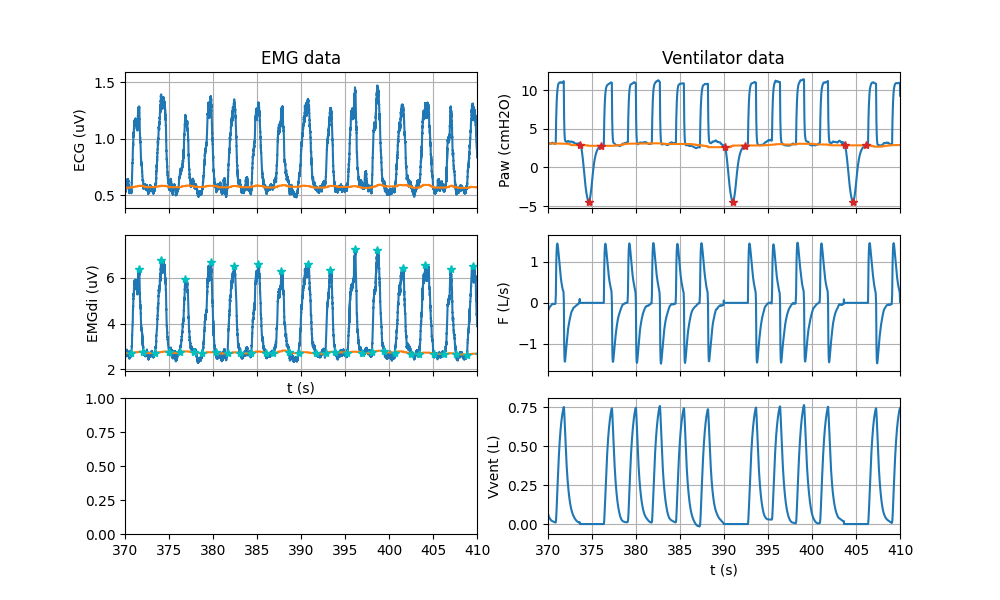

In [20]:
# Plot the raw data
fig, axis = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), sharex=True)
axes_emg = axis[:-1, 0]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
# emg_timeseries.plot_full(axes_emg, signal_type='clean', baseline_bool=False)
# emg_timeseries.plot_full(axes_emg, signal_type='env', colors=colors)
emg_timeseries.plot_full(axes_emg, signal_type='env')
emg_di.plot_markers(peak_set_name='breaths', axes=axes_emg[1], colors='c')
axes_emg[0].set_title('EMG data')
axes_emg[-1].set_xlabel('t (s)')

axes_vent = axis[:, 1]
vent_timeseries.plot_full(axes_vent)
paw.plot_markers(peak_set_name='Pocc', axes=axes_vent[0])

axes_vent[0].set_title('Ventilator data')
axes_vent[-1].set_xlabel('t (s)')
axes_vent[-1].set_xlim([370, 410])

In [ ]:
# Plot the peaks
n_peaks = len(emg_di.peaks['breaths'].starts_s)
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_di.plot_peaks(axes=axes_emg, peak_set_name='breaths', signal_type='raw')
emg_di.plot_peaks(axes=axes_emg, peak_set_name='breaths', colors=colors)
emg_di.plot_markers(axes=axes_emg, peak_set_name='breaths')

axes_vent = axis[1, :]
paw.plot_peaks(axes=axes_vent, peak_set_name='breaths')

for axis in axes_vent:
    axis.set_xlabel('t (s)')

In [ ]:
# # Plot the peaks
# n_peaks = len(emg_di.peaks['breaths'].starts_s)
# fig, axis = plt.subplots(nrows=6, ncols=n_peaks, figsize=(10, 10), 
#                          sharex='col', sharey='row')

# axes_emg = axis[:3, :]
# colors = ['tab:cyan', 'tab:orange', 'tab:red']
# emg_timeseries.plot_peaks(axes=axes_emg, peak_set_name='breaths', signal_type='raw')
# emg_timeseries.plot_peaks(axes=axes_emg, peak_set_name='breaths', colors=colors)
# emg_timeseries.plot_markers(axes=axes_emg, peak_set_name='breaths')

# axes_vent = axis[3:, :]
# vent_timeseries.plot_peaks(axes=axes_vent, peak_set_name='breaths')

# for axis in axes_vent[-1]:
#     axis.set_xlabel('t (s)')

# Plot only the existing peak sets:
n_peaks = len(emg_di.peaks['breaths'].starts_s)
fig, axis = plt.subplots(nrows=2, ncols=n_peaks, figsize=(10, 6), 
                         sharex='col', sharey='row')

axes_emg = axis[0, :]
colors = ['tab:cyan', 'tab:orange', 'tab:red']
emg_timeseries.plot_peaks(axes=axes_emg, peak_set_name='breaths', signal_type='raw', channel_idxs=[1])
emg_timeseries.plot_peaks(axes=axes_emg, peak_set_name='breaths', colors=colors, channel_idxs=[1])
emg_timeseries.plot_markers(axes=axes_emg, peak_set_name='breaths', channel_idxs=[1])

axes_vent = axis[1, :]
vent_timeseries.plot_peaks(axes=axes_vent, peak_set_name='breaths', channel_idxs=[0])

for axis in axes_vent:
    axis.set_xlabel('t (s)')